In [1]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAEOutput
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
RNG_KEY = jax.random.PRNGKey(42)

In [3]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [4]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  decoder_params: Optional[Params] = None
  
CAR_ARGS = CARArgs()

In [5]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.7))
  # alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

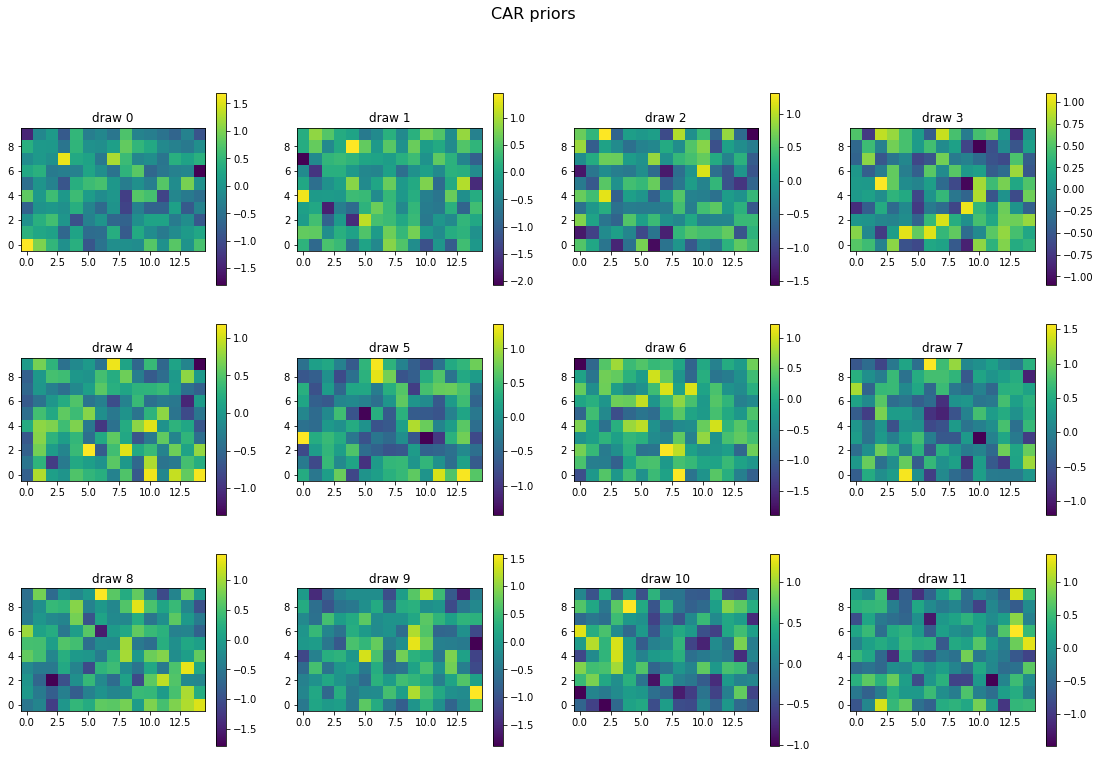

In [6]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=1000)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [7]:
SCALE = 1.0

def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return SCALE * car_draws

# Training VAE

In [8]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  
  batch_size: int = 100
  
  hidden_dim: int = 130
  latent_dim: int = 130
  output_dim: int = A.shape[0]
  
  learning_rate: float = 1e-3
  epochs: int = 5000
  
  eval_frequency: int = 10
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x130e61d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=5000, eval_frequency=10)


## PriorVAE model

In [9]:
from typing import Tuple

ACT_FN = jax.nn.elu

def priorvae_encoder(
        x: jnp.ndarray,
        hidden_dim: int,
        latent_dim: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Encoder for PriorVAE."""
    x = hk.Flatten()(x)
    x = hk.Sequential(
        [
            hk.Linear(hidden_dim),
            ACT_FN,
        ]
    )(x)
    mean = hk.Linear(latent_dim, name='mean')(x)
    log_std = hk.Linear(latent_dim, name='log_std')(x)
    return mean, log_std


def priorvae_decoder(
        z: jnp.ndarray,
        hidden_dim: int,
        output_dim: int) -> jraph.GraphsTuple:
    output = hk.Sequential(
        [
            hk.Linear(hidden_dim, name='decoder_hidden'),
            ACT_FN,
            hk.Linear(output_dim, name='output'),
        ]
    )(z)
    output = jnp.reshape(output, (-1, output_dim))
    return output


class PriorVAE(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_dim: int,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, x: jnp.ndarray) -> VGAEOutput:
        x = x.astype(jnp.float32)
        mean, log_std = priorvae_encoder(
            x,
            self._hidden_dim,
            self._latent_dim,
        )

        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)

        output = priorvae_decoder(
            z,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, std, output)

In [10]:
net = hk.transform(
  lambda x: PriorVAE(
    hidden_dim=ARGS.hidden_dim,
    latent_dim=ARGS.latent_dim, 
    output_dim=ARGS.output_dim)(x))

In [11]:
optimizer = optax.adam(learning_rate=ARGS.learning_rate)

In [12]:
@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    batch: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, batch)
  
  log_likelihood = -log_likelihood_loss_fn(outputs.output, batch)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = 10**4*log_likelihood - kld
  
  return -elbo
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    batch: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [13]:
# Initialize net with an arbitrary graph
RNG_KEY, rng_init, rng_params = jax.random.split(RNG_KEY, 3)

init_batch = generate_car_batch(rng_init, batch_size=ARGS.batch_size)
params = net.init(rng_params, init_batch)
opt_state = optimizer.init(params)

In [14]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):   
  update_rng, train_data_rng = jax.random.split(jax.random.fold_in(train_rng, epoch))
  
  train_batch = generate_car_batch(train_data_rng, batch_size=ARGS.batch_size)
  params, opt_state = update(params, update_rng, opt_state, train_batch)
  
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng, val_data_rng = jax.random.split(evaluate_rng, 3)
    
    train_loss = loss_fn(params, train_loss_rng, train_batch)
    
    val_batch = generate_car_batch(val_data_rng, batch_size=ARGS.batch_size)
    val_loss = loss_fn(params, eval_loss_rng, val_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x130e61d30>
01:27:15 STEP: 0; Train loss: 9503.763; Validation loss: 9736.646
01:27:21 STEP: 10; Train loss: 6900.558; Validation loss: 6981.197
01:27:26 STEP: 20; Train loss: 5504.066; Validation loss: 5642.840
01:27:32 STEP: 30; Train loss: 4747.318; Validation loss: 4739.299
01:27:38 STEP: 40; Train loss: 4261.408; Validation loss: 4307.477
01:27:43 STEP: 50; Train loss: 3860.622; Validation loss: 3934.419
01:27:49 STEP: 60; Train loss: 3713.314; Validation loss: 3679.515
01:27:55 STEP: 70; Train loss: 3471.262; Validation loss: 3528.083
01:28:01 STEP: 80; Train loss: 3415.079; Validation loss: 3375.086
01:28:07 STEP: 90; Train loss: 3256.476; Validation loss: 3260.759
01:28:12 STEP: 100; Train loss: 3124.653; Validation loss: 3121.347
01:28:18 STEP: 110; Train loss: 3110.207; Validation loss: 3084.858
01:28:24 STEP: 120; Train loss: 2998.237; Validation loss: 3065.187
01:28:31 STEP: 130; Train loss: 2927.943; Validation loss: 2970.018
01:28:38

104 mins (= 1.7 hours) to train in total.

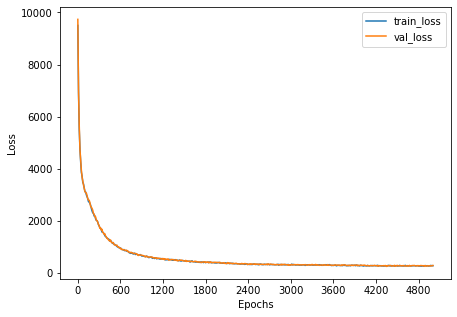

In [15]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(7, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xs = np.arange(len(train_losses))*ARGS.eval_frequency
plt.plot(xs, train_losses, label='train_loss')
plt.plot(xs, val_losses, label='val_loss')

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

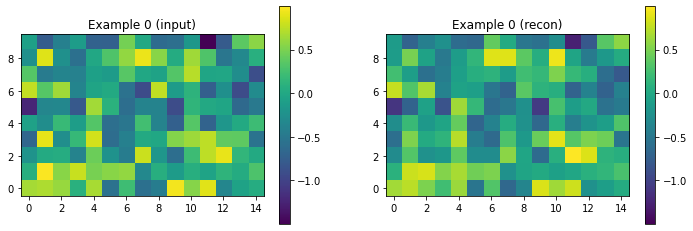

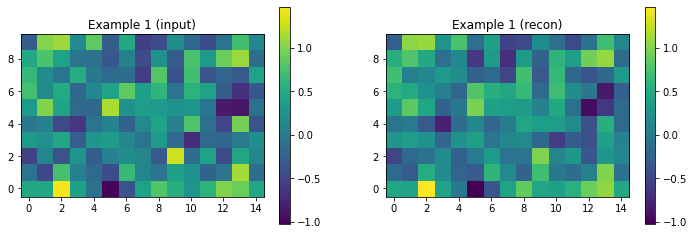

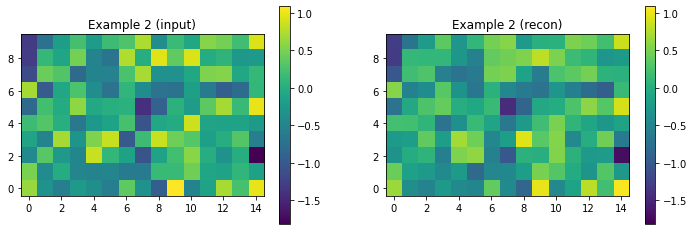

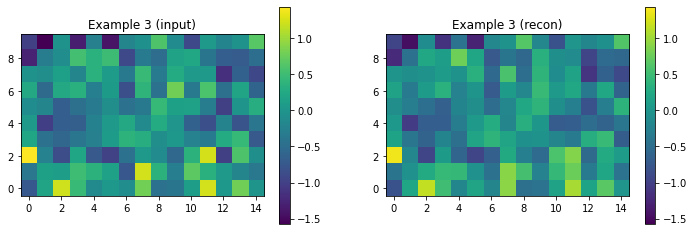

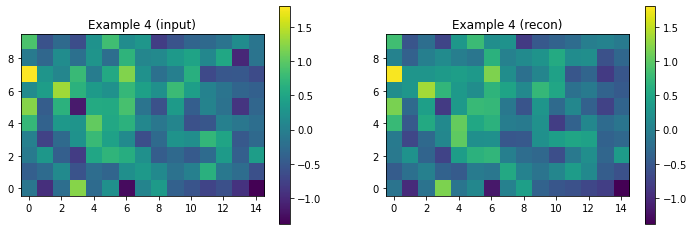

In [16]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    data_rng = jax.random.fold_in(rng_recon, i)
    data_batch = generate_car_batch(data_rng, batch_size=ARGS.batch_size)
    outputs = net.apply(params, RNG_KEY, data_batch)
    out = outputs.output

    example_image = jnp.ravel(data_batch[0])
    recon_image = jnp.ravel(out[0])

    ax, _ = plotting.plot_images_from_arrays(
        arrays=[example_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
        # custom_min=-0.1,
        # custom_max=0.1,
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')

SAVE THIS MODEL

In [17]:
params.keys()

dict_keys(['prior_vae/decoder_hidden', 'prior_vae/linear', 'prior_vae/log_std', 'prior_vae/mean', 'prior_vae/output'])

In [32]:
decoder_params = {
  'decoder_hidden': params['prior_vae/decoder_hidden'],
  'output': params['prior_vae/output'],
}
CAR_ARGS.decoder_params = decoder_params

decoder_net = hk.without_apply_rng(hk.transform(
  lambda z: priorvae_decoder(z, 
                             hidden_dim=ARGS.hidden_dim, 
                             output_dim=ARGS.output_dim))
)

In [33]:
from pathlib import Path

model_name = (
  f'priorVAE_CAR_'
  f'h{ARGS.hidden_dim}l{ARGS.latent_dim}_' 
  f'lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
  f'batchSize{ARGS.batch_size}'
)
print(model_name)

model_path = Path('./models/priorVAE') / model_name
print(model_path)

priorVAE_CAR_h130l130_lr0.001_epochs5000_batchSize100
models/priorVAE/priorVAE_CAR_h130l130_lr0.001_epochs5000_batchSize100


In [34]:
from model import save_params

SAVE_MODEL = False

if SAVE_MODEL:
    model_path.mkdir(exist_ok=True, parents=True)
    save_params(model_path, params)
    print(f'Saved to path: {model_path}')

In [46]:
ARGS.latent_dim

130

In [56]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x130e61d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=5000, eval_frequency=10)


In [51]:
jnp.squeeze(decoder_net.apply(CAR_ARGS.decoder_params, z)).shape

(150,)

In [35]:
def vae_predictive_model(args: CARArgs, 
                       y: Optional[jnp.ndarray] = None, 
                       noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    
    # The transpose is because we initially used 
    # more than one samples ~ N(0, 1) as features for each node
    out = jnp.squeeze(decoder_net.apply(args.decoder_params, z).T)
    
    car_vae = numpyro.deterministic('car_vae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vae, noise), obs=y)

In [36]:
vae_preds = Predictive(vae_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
vae_draws = vae_preds['car_vae']

car_preds = Predictive(car_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

assert vae_draws.shape == car_draws.shape, 'vae_draws dimensions do not match car_draws dimensions'

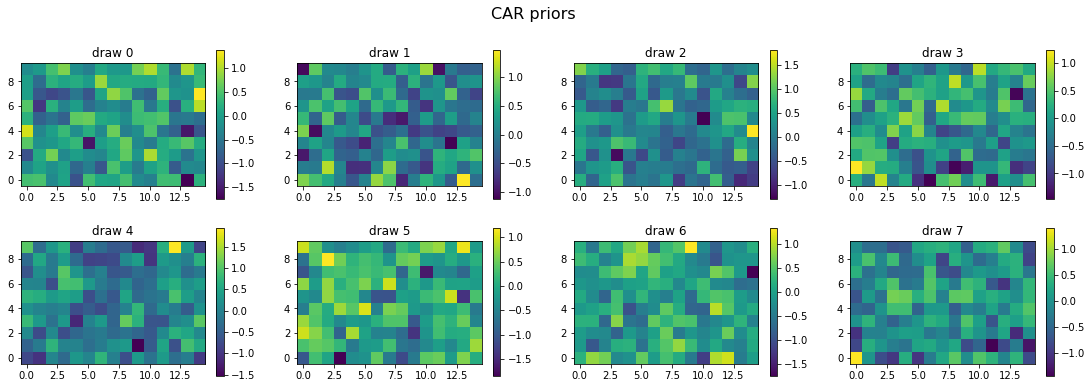

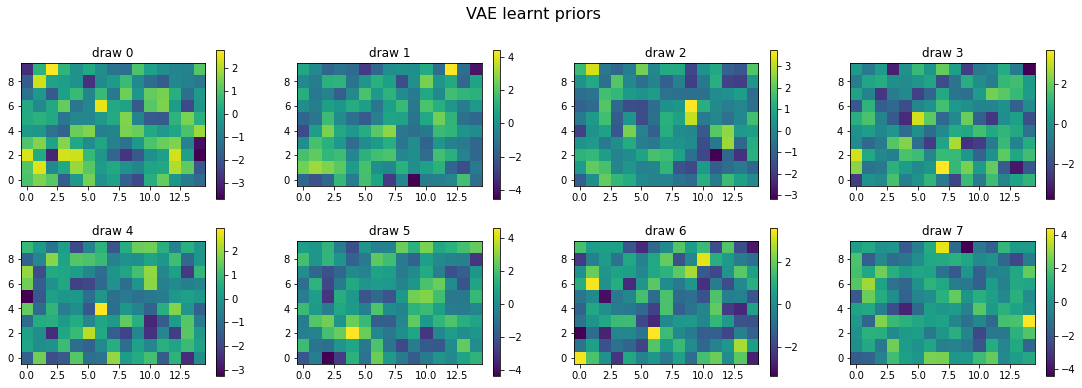

Args(loss_fn=<function compute_mse_loss at 0x130e61d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=5000, eval_frequency=10)


In [38]:
plotting.plot_samples(car_draws, rows=2, figsize=(19, 6), image_shape=IMAGE_SHAPE)
plotting.plot_samples(vae_draws, rows=2, figsize=(19, 6), title=f'VAE learnt priors', image_shape=IMAGE_SHAPE)
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x130e61d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=5000, eval_frequency=10)


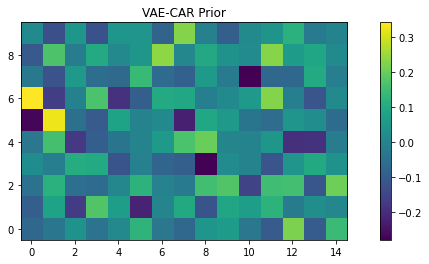

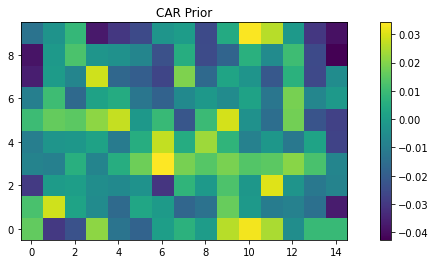

In [39]:
# VAE-CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_samples = 1000
car_draws = Predictive(car_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car']
vae_draws = Predictive(vae_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car_vae']

mean_prior_pred_vae = np.mean(vae_draws, axis=0)
hpdi_prior_pred_vae = hpdi(vae_draws, 0.89)
mean_prior_pred_car = np.mean(car_draws, axis=0)
hpdi_prior_pred_car = hpdi(car_draws, 0.89)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_vae],
    titles=['VAE-CAR Prior'],
    image_shape=IMAGE_SHAPE,
)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_car],
    titles=['CAR Prior'],
    image_shape=IMAGE_SHAPE,
);

In [40]:
def car_predictive_model_with_noise(
    args: CARArgs, y=None, alpha=None, noise=None) -> None:
    A = args.adj_matrix
    D = jnp.diag(args.degree_vector)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha*A)
    
    car = numpyro.sample(
        'car', dist.MultivariateNormal(
            loc=jnp.zeros(num_regions), precision_matrix=Q))
    numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car, noise), obs=y)

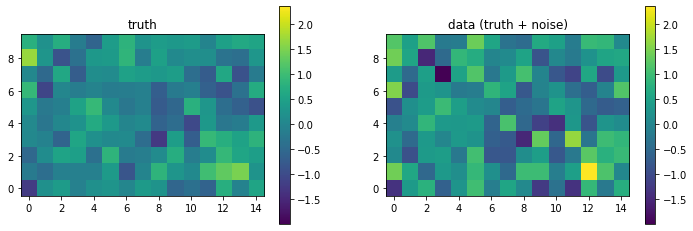

In [41]:
# Generate ground truth - fix alpha
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_predictive = Predictive(car_predictive_model_with_noise, num_samples=1)
car_preds = car_predictive(rng_pred, CAR_ARGS, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data],
    titles=['truth', 'data (truth + noise)'],
    image_shape=IMAGE_SHAPE
);

In [42]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(vae_predictive_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel,
    num_warmup=2000, 
    num_samples=2000,
)
mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 4000/4000 [00:09<00:00, 430.01it/s, 15 steps of size 2.40e-01. acc. prob=0.83] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  car_vae[0]     -0.70      0.45     -0.71     -1.39      0.10   2160.40      1.00
  car_vae[1]      0.45      0.44      0.45     -0.27      1.21   1810.25      1.00
  car_vae[2]      0.32      0.42      0.33     -0.40      0.97   2029.89      1.00
  car_vae[3]     -0.33      0.41     -0.33     -1.00      0.34   2216.15      1.00
  car_vae[4]     -0.00      0.41     -0.02     -0.68      0.66   1799.30      1.00
  car_vae[5]      1.05      0.46      1.06      0.29      1.79   1783.64      1.00
  car_vae[6]     -0.11      0.43     -0.11     -0.78      0.66   1831.58      1.00
  car_vae[7]      0.13      0.42      0.14     -0.61      0.79   2203.21      1.00
  car_vae[8]      0.23      0.40      0.23     -0.47      0.85   2787.81      1.00
  car_vae[9]     -0.69      0.44     -0.69     -1.42      0.01   1735.72      1.00
 car_vae[10]     -0.24      0.41     -0.25     -0.92      0.43   2285.00      1.00
 ca

In [44]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car_vae']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 27 s
Average ESS for all CAR effects : 2013


Args(loss_fn=<function compute_mse_loss at 0x130e61d30>, batch_size=100, hidden_dim=130, latent_dim=130, output_dim=150, learning_rate=0.001, epochs=5000, eval_frequency=10)


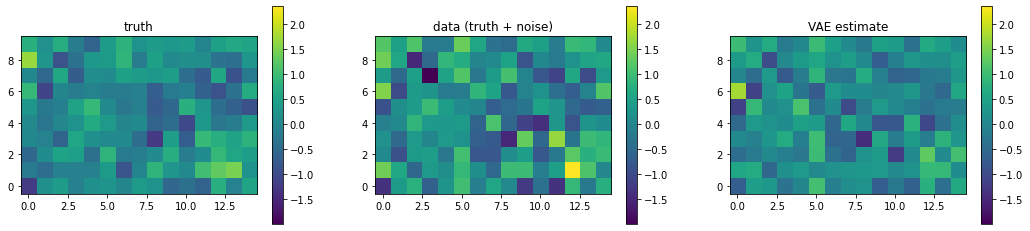

In [45]:
# Posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

posterior_predictions = Predictive(vae_predictive_model, mcmc_samples)(rng_pred, CAR_ARGS)
post_obs = posterior_predictions['car_vae']

mean_post_pred_vae = np.mean(post_obs, axis=0)
bci_vae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vae],
    titles=['truth', 'data (truth + noise)', 'VAE estimate'],
    figsize=(18, 4),
    image_shape=IMAGE_SHAPE,
);